# Data Wrangling

There are standard data exploring and cleaning (section "Inspecting data") and basic data wrangling procedures (Step 1 of "Transforming Data") contained in this script. However, some heavier data transformations also happen in the "Transforming Data" section, with the most complex parts being 3 and 5. In step 3, view and complete events are allocated to offer received events. Block ids for these sets of events that identify which receive, view and complete belong together are created. In step 5, the transactions are allocated to these blocks.

## Setup

In [2]:
import pandas as pd
import numpy as np
import math
import json
import os
#% matplotlib inline
from pandasql import sqldf
from matplotlib import pyplot as plt

In [3]:
os.chdir(r'C:\Users\j\Documents\udacity-ds-nanodegree\starbucks-project')

In [4]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Inspecting data

In this section, I inspect all three dataframes to assert data quality, define steps for data cleaning, and get a first impression of the data.
Further exploration can only be carried out after complex data transformations, which will also be required to carry out the actual analysis.

In [ ]:
profile.head(5)

In [54]:
portfolio.head(10)

,offer_reward,offer_difficulty,offer_duration,offer_type,id,offer_valid_until,email,mobile,social,web
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,NaN,1,1,1,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,NaN,1,1,0,1
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1,1,0,1
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1,0,0,1
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,1,1,1,1
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,NaN,1,1,1,1
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,NaN,1,1,1,0
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,NaN,1,1,1,1
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,NaN,1,1,0,1


In [55]:
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### profile data

#### Summary of inspection of data in profile table:
* As I cannot judge if this is a representative sample of the Starbucks App user population, I will assume it is.
* The table only contains **unique records** of app-users. No deduplication is needed.
* Around 12.8% of these users have **missing information** for all three demographic variables. I believe that this data should not be imputed. It cannot be *derived/predicted* from any other variables, as all other variables will be part of the prediction model. In addition, these demographic values will be important predictors for the model themselves, therefore imputation like using the mean/median or mode seems too "rough" an approach. I will instead check if the people without information are systematically different from those with information, and if not, I will drop the records. In order to make this assessment, the data needs to be transformed.
* The **gender** is not 50-50, as would be expected from the general population. It is, however, possible that the split is representative of the wider Starbucks App subscriber population.
* The **age** distribution suggests that the sample is rather old, which I find surprising for Stabrucks users. Other than that the age range seems plausible.
* The  **income** appears to have been capped both at the lower and higher end. Other than that the distribution seems plausible, showing the typical right skew that income data often displays.
* The **membership** column has no missings and the data range is plausible. Most memberships are more recent, which makes sense considering that consumers probably drop out after a certain amount of time.

In [ ]:
# Number of unique users, check for duplicates
print("Number of unique user: ",profile['id'].nunique())
print("Number of users in df: ",profile.shape[0])

In [ ]:
# Assess "gender" column
print("Categorical codes for gender column: ",profile['gender'].value_counts())
print("Number of missing values in gender column: ",profile['gender'].isna().sum())

In [ ]:
# Assess "age" column distribution, code 118 is missing information
profile['age'].hist() # >> surprisingly old population considering company is Starbucks

# Recode 118 inta np.nan
profile.loc[profile['age'] == 118, 'age'] = np.nan

# get min and max values, and missing values
print("Lowest age in dataset: ",profile['age'].min())
print("Highest age in dataset: ", profile['age'].max())
print("Number of missing values in age column: ",profile['age'].isna().sum())

In [ ]:
# Assess "income" column distribution
profile['income'].hist() # >> I assume income was cropped at a min and max value

# get min and max values, and missing values
print("Lowest age in dataset: ",profile['income'].min())
print("Highest age in dataset: ", profile['income'].max())
print("Number of missing values in income column: ",profile['income'].isna().sum())

In [ ]:
# Check if the missings are the same for all three columns
all_missing = profile.loc[(profile['income'].isna()) & (profile['age'].isna()) & (profile['gender'].isna())].shape[0]
print("Records that have all three demographic attributes missing: ",all_missing)

In [ ]:
# Assess share of records without demographic information out of all records
all_missing/profile.shape[0] #>> I would lose 12.8% of the data

Need to assess if those who did not provide demographic data are systematically different from those who did to decide if I can remove them from the sample. I will compare:
* Total spend and offers completed: Those are variables that I will **predict**, so there should not be any bias in them
* offers received and type of offer received: That is the **experimental setup** and I do not want this to be biased
In order to assess this, I need to maipulate the transcipt df a bit. I need to extract amount for instance

In [ ]:
# Assess "membership" column
# Change to datetime format
'''
Source: https://datatofish.com/integers-datetime-pandas-dataframe/, Auagust 14th 2021
'How to convert Integers to datetime in Pandas DataFrame'
'''
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')

In [ ]:
print("Earliest membership date: ",profile['became_member_on'].min())
print("Latest membership date: ",profile['became_member_on'].max())
profile['became_member_on'].hist()
plt.show()

### portfolio data

#### Summary of inspection of data in portfolio table
* There is total of 10 offers
* Intuitively, the expectation would be that a reward rises with difficulty, and that duration rises with difficulty. 
* When examining the data through scatterplots, this relationship is not actually that clear. There are some offers that appear  less attractive than others.
* However, these offers vary on further attributes, like type and channels

In [ ]:
portfolio.head(10).sort_values(by=['offer_type'])

In [ ]:
# Check uniqueness of offer ids
portfolio['id'].nunique()

In [ ]:
# Number of offers per type
portfolio['offer_type'].hist()
plt.show()

In [ ]:
# examining relationship between attributes
plt.scatter(portfolio['reward'], portfolio['difficulty'])
plt.xlabel('reward')
plt.ylabel('difficulty')
plt.show()

In [ ]:
# examining relationship between attributes
plt.scatter(portfolio['duration'], portfolio['difficulty'])
plt.xlabel('duration')
plt.ylabel('difficulty')
plt.show()

### transaction data

#### Summary of inspection of data in transaction table
* The logical funnel for an offer is *receive >> view >> complete*
* However, this funnel can be shortened to *receive >> view* and also to *receive >> complete*, or switched to *receive >> complete >> view*
* The maximum number of offers someone can receive is 6
* Most people receive 5 offers
* Most people view 3 offers
* Most people complete 2 offers

In [ ]:
# How many offers does a person receive >> histogram
offers_h = transcript.loc[transcript['event'] == 'offer received'].groupby(['person']).size()
views_h = transcript.loc[transcript['event'] == 'offer viewed'].groupby(['person']).size()
completes_h = transcript.loc[transcript['event'] == 'offer completed'].groupby(['person']).size()

In [ ]:
# max number of offers, needed to define bins in histogram
offers_h.max()

In [ ]:
# Version with transparent bars - user version from below, just keep this code for reference. Alpha makes transparent, the lower alpha the more transparent.
plt.hist(offers_h, bins = [1,2,3,4,5,6,7],alpha = 0.3, align = 'left')
plt.hist(views_h, bins = [1,2,3,4,5,6,7], alpha = 0.3, align = 'left')
plt.hist(completes_h, bins = [1,2,3,4,5,6,7], alpha = 0.3, align = 'left')
plt.show()

In [ ]:
# Version with bars side by side
# Source Stackoverflow: https://stackoverflow.com/questions/6871201/plot-two-histograms-on-single-chart-with-matplotlib
# Question by Open the way: https://stackoverflow.com/users/171546/open-the-way
# Answer by Gustavo Bezerra: https://stackoverflow.com/users/2132753/gustavo-bezerra
plt.hist([offers_h, views_h, completes_h], bins = [1,2,3,4,5,6,7], align = 'left', label = ['received', 'viewed', 'completed'])
plt.legend()
plt.show()

## Transforming data
* **Step 1:** Wrangle all three dataframes and create master df which is based on transaction frame but without transactions. This df will be transformed to be fit for analysis.
* **Step 2:** Answer some relevant questions about the general experimental setup
* **Step 3:** Transform master df to create a table which has one record per person and offer, and which contains additional information on this particular offer.
* **Step 4:** Create derived variables
* **Step 5:** Add transaction value dataframe: matrix person on offer and no_offer and avg value.
Start with a person x hour df where each hour has a 0 (no offer) to 10, and then you can use that to lookup the transaction's value maybe? Too simple I guess, check your transaction allocation logic again.

### Step 1: Wrangling all three dataframes

In [5]:
# profile data
'''
Source: https://datatofish.com/integers-datetime-pandas-dataframe/, Auagust 14th 2021
'How to convert Integers to datetime in Pandas DataFrame'

Source: Stackoverflow: https://stackoverflow.com/questions/53986451/calculate-date-difference-between-todays-date-and-pandas-date-series/53986547
Question by Shivam: https://stackoverflow.com/users/10851563/shivam
Answer by k88: https://stackoverflow.com/users/5682512/k88

Source: Satckoverflow: https://stackoverflow.com/questions/2119472/convert-a-timedelta-to-days-hours-and-minutes
Question by Oli: https://stackoverflow.com/users/12870/oli
Answer by Alex Martelli: https://stackoverflow.com/users/95810/alex-martelli
'''
# Calculating duration of membership
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile['membership_duration'] = profile['became_member_on'] - pd.to_datetime("now")
profile['membership_duration'] = profile['membership_duration'].dt.days

In [6]:
# portfolio data
# Calculating until when offer is valid
portfolio = portfolio.rename(columns={'reward':'offer_reward','channels':'offer_channels','difficulty':'offer_difficulty', 'duration':'offer_duration'})
portfolio['offer_duration'] = portfolio['offer_duration']*24
portfolio['offer_valid_until'] = np.nan


# One-hot-encoding channels
# Source Stackoverflow: https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list
# Question by Melsauce: https://stackoverflow.com/users/5858873/melsauce
# Answer by piRsquared: https://stackoverflow.com/users/2336654/pirsquared
portfolio = portfolio.drop('offer_channels',1).join(portfolio['offer_channels'].str.join('|').str.get_dummies())

In [44]:
# Transaction data >> create master frame
'''
Source: Stackoverflow: https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas
Question by Ilaffin: https://stackoverflow.com/users/6157698/llaffin
Answer by joris: https://stackoverflow.com/users/653364/joris
'''

# Turning the value column which lists different events into separate columns
master = pd.concat([transcript, pd.DataFrame(transcript['value'].tolist())], axis=1)

# There are cases where the offer id is offer_id in the 'value' dictionary. Need to combine both columns.
'''
Source: Stackoverflow: https://stackoverflow.com/questions/34989341/how-to-remove-nan-value-while-combining-two-column-in-panda-data-frame
Question by imSonuGupta: https://stackoverflow.com/users/3101669/imsonugupta
Answer by jpp: https://stackoverflow.com/users/9209546/jpp
'''
master['offer id'].update(master.pop('offer_id'))
master = master.rename(columns={'offer id':'event_offer_id','amount':'event_amount','reward':'event_reward'})

# Removing all transaction records
master = master.loc[master['event'] != 'transaction']
# Remove event_amount column as not needed
master = master.drop('event_amount', axis = 1)

KeyError: "['event_amount'] not found in axis"

In [8]:
# Merging portfolio table
master = pd.merge(master, portfolio[['offer_type','offer_reward','offer_difficulty','offer_duration','email','web','social','mobile']], how = 'left', left_on = master['event_offer_id'], right_on = portfolio['id'])
master = master.drop('key_0', axis = 1)

# Creating derived variable offer_valid_until
master.loc[master['event'] == 'offer received', 'offer_valid_until'] = master['time'] + master['offer_duration']

### Step 2: Understand experiment setup in more detail

#### When do offers get sent out? >> At 6 distinct points in time. They are not spaced out evenly, and a slightly different amount of offers is sent out each time

In [10]:
master_receive = master.loc[master['event'] == 'offer received']
master_receive_gr = pd.DataFrame(master_receive.groupby(['time']).size().reset_index())

In [11]:
master_receive_gr

,time,0
0,0,12650
1,168,12669
2,336,12711
3,408,12778
4,504,12704
5,576,12765


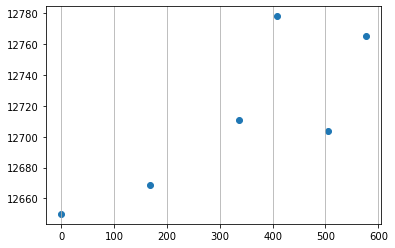

In [12]:
minor_ticks = np.arange(0,600,24)
plt.scatter(master_receive_gr['time'],master_receive_gr[0])
plt.grid(axis = 'x')
plt.show()

#### Does a specific offer only get sent out at one point in time? >> No
#### Do different offers get sent out at the same time? >> Yes

In [13]:
pd.crosstab(master_receive['event_offer_id'],master_receive['time'])

time,0,168,336,408,504,576
event_offer_id,,,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,1297,1245,1322,1269,1258,1277
2298d6c36e964ae4a3e7e9706d1fb8c2,1221,1250,1301,1274,1286,1314
2906b810c7d4411798c6938adc9daaa5,1257,1270,1263,1335,1286,1221
3f207df678b143eea3cee63160fa8bed,1273,1266,1279,1275,1229,1295
4d5c57ea9a6940dd891ad53e9dbe8da0,1218,1240,1280,1308,1310,1237
5a8bc65990b245e5a138643cd4eb9837,1266,1270,1256,1293,1238,1295
9b98b8c7a33c4b65b9aebfe6a799e6d9,1245,1296,1275,1274,1261,1326
ae264e3637204a6fb9bb56bc8210ddfd,1292,1319,1245,1278,1248,1276
f19421c1d4aa40978ebb69ca19b0e20d,1263,1263,1247,1250,1305,1243


#### Can a person receive the same offer multiple times? >> Yes, the maximum a person has received the same offer is 5 times

In [14]:
pd.crosstab(master_receive['person'], master_receive['event_offer_id']).max().max()

5

#### Can a person receive a new offer whilst another one is still active? >> Yes, this happens frequently

In [15]:
# Creating subset
offer_logic_check = master_receive[['person','event_offer_id','time','offer_valid_until']].sort_values(by=['person', 'time'])

In [16]:
 # shifting row values one row down
offer_logic_check['shift_time'] = offer_logic_check['offer_valid_until'].shift(periods = 1)
offer_logic_check['shift_person'] = offer_logic_check['person'].shift(periods = 1)
# Create checking column, populate only with 0
offer_logic_check['previous_offer_still_valid'] = 'no overlap'
# Populate checking column with 1 if new offer overlaps with previous offer
offer_logic_check.loc[(offer_logic_check['shift_person'] == offer_logic_check['person']) & (offer_logic_check['shift_time'] > offer_logic_check['time']),'previous_offer_still_valid'] = 'overlap'
# Count occurences where new offer overlaps with previous offer
offer_logic_check['previous_offer_still_valid'].value_counts()

no overlap    46730
overlap       29547
Name: previous_offer_still_valid, dtype: int64

#### Can a person receive a new offer whilst still being aware of an active, not completed offer? >> Yes, seen upon visual inspection of the data
#### If yes, can this be the *same* offer? >> Yes, seen upon visual inspection of the data

### Step 3: Wrangle master table

#### Step 3.1 Identify unique blocks of offer receive events with views and completes

I need to be able to uniquely identify an "offer block". An offer block defines a person-x-offer combination, where an offer block starts with a receive and contains *exactly* one receive, and a maximum of one view and one complete. I will achieve this in two stages:
* In a first step, I will assign an ID to each offer block that uniquely identifies a person x offer combination
* Following this, I will split up offer blocks that still contain multiple receives because a person received a specific offer multiple times.

Finally, I will do some data checks

##### Step 3.1.1

In [20]:
# Sort the master dataframe. This is essential for the further steps.
master = master.sort_values(by=['person', 'event_offer_id', 'time'])

In [21]:
# Create a dataframe that creates a unique identifier for each person and offer combination
person_offer_id_df = master.loc[master['event'] == 'offer received', ['person', 'event_offer_id']].drop_duplicates().reset_index().rename(columns={'index':'person_offer_id'})
# Merge the id back into the master dataframe
master = pd.merge(master, person_offer_id_df, how = 'left', left_on = ['person','event_offer_id'], right_on = ['person','event_offer_id'])
# Note: This only affect event: receive, view and complete, because transactions do not have an event_offer_id. This will be tackled later-on.

In [22]:
# Because one person can receive the same offer multiple times, some offer blocks will have multiple offer received. 
# The most times one person has received the same offer is:
max_same_offer = master.loc[master['event'] == 'offer received'].groupby(by=['person_offer_id']).size().max()
print("The most times one person has received the same offer is:", max_same_offer)

The most times one person has received the same offer is: 5


##### Step 3.1.2

Because one person can receive the same offer multiple times, these offer blocks need to be broken down further into offer blocks, where each "receive" starts its own offer block. First, I need to identify the person_offer_ids where the block has multiple receives.

In [23]:
receives_per_block = master.loc[master['event'] == 'offer received'].groupby(by=['person_offer_id']).size()

In [24]:
receives_per_block_df = pd.DataFrame(receives_per_block)

In [25]:
blocks_need_subsplit = receives_per_block_df.loc[receives_per_block_df[0] > 1].index.tolist()

Now I will loop through these blocks and split them up into separate blocks.
Approach:
* Create a subset of the m2 dataframe that only contains records that belong to the specific person_offer_id
* Identify indices of "offer receive" records.
* Loop through each "offer receive" record. Allocate views and completes to the receive record. Mark receive, view and complete records that belong together with the same number in the 'sub_block' column.
* The allocation logic is:
> * Begin the loop at the earliest "receive".
> * In each loop, allocate a maximum of one view and one complete to the receive.
> * The views and completes get allocated to the earliest receive in whose validity time-frame they fall, unless that receive already has a view and complete allocated.
> * If a view or complete is "taken" by a receive, it cannot be re-allocated to another receive.
> * A view and a complete can only ever be allocated to one receive.


In [26]:
# Establish list to store block allocations
sub_block_list = []

In [27]:
for person_offer_id in blocks_need_subsplit: 
    # create the dataframe-subset of interest
    df = master.loc[master['person_offer_id'] == person_offer_id][['event','offer_valid_until','time']]
    df['sub_block'] = np.nan
    # Create a dictionary to store the indices, valid_untils and timestamps (i.e. time of reception) of receive records
    receive_dict = df.loc[df['event'] == 'offer received'][['offer_valid_until','time']].reset_index().to_dict(orient = 'records')
  
    # Loop through the "receive" records and allocate views and completes
    for i in range(len(receive_dict)):
        # set key variables for filtering
        offer_start_time = receive_dict[i]['time']
        validity = receive_dict[i]['offer_valid_until']
        # filter the block for views and receives within the right timeframe (from offer receive to offer validity end). Only keep such views and completes that do not yet belong to another receive
        df_for_loop = df.loc[(df['time'] <= validity) & (df['time'] >= offer_start_time) & (df['event'] != 'offer received') & (df['sub_block'].isna())]
        # reset the index
        df_for_loop = df_for_loop.reset_index()
        # number the rows using sql and select only the first entries
        df_from_loop = sqldf("SELECT * FROM (SELECT *, row_number() over (partition by event order by time) as counter_check_inner2 FROM df_for_loop) as subtable WHERE counter_check_inner2 = 1")
        
        #??????# Add a step where you only keep the "view" as belonging to the receive when it precedes the complete? It is currently unclear if s.o. can view after completion
        
        # extract the indices of the rows that belong to the "receive" you are examining in this loop
        rows_affected_list = df_from_loop['index'].to_list()

        # mark the "receive" you are assessing in the original data, so it is clear it belongs to a specific offer block
        df.loc[df.index == receive_dict[i]['index'], 'sub_block'] = i 
        # now mark the "view" and "complete" rows in the original df, so it is clear they belong to this specific "receive"
        df.loc[df.index.isin(rows_affected_list), 'sub_block'] = i 
        #print(df)
           
    # Create a dictionary with index and block allocation
    df = df.reset_index()
    allocation = df[['index','sub_block']].to_dict(orient = 'records')
    # Append this dictionary to the sub_block_list
    sub_block_list.append(allocation)
        

In [28]:
# Flattening the resulting list into a list of dicts
# https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
# Question by Emma: https://stackoverflow.com/users/110527/emma
# Answer by Alex Martelli: https://stackoverflow.com/users/95810/alex-martelli
flat_list = [i for i in sub_block_list for i in i]

In [29]:
# Filling NaNs in flat list with 9999, so I can delete them lateron. 
# These NaN values are "views" of expired offers and are hence irrelevant for offer awareness. They can be deleted.
df_flat_list = pd.DataFrame(flat_list)
df_flat_list.loc[df_flat_list['sub_block'].isna(), 'sub_block'] = 9999

### ----------------------   Start of investigation   ----------------------------------------------------------------------------------

In [ ]:
# Inspecting my flat list, because it has NaN values
df_flat_list = pd.DataFrame(flat_list)
df_flat_list.loc[df_flat_list['sub_block'].isna()]

In [ ]:
# Understanding why there are nans in my flat list

In [ ]:
# finding person_offer_id of an example case
master.loc[41162]

In [ ]:
m2x.loc[m2['person_offer_id'] == 191][['person','event','time','offer_duration','event_offer_id','offer_valid_until','sub_block']]

In [ ]:
# checking I created my block correctly >> I did
m2.loc[(m2['person'] == '1c587de019994f93a242c6864fd7bc55') & (m2['event_offer_id'] == 'ae264e3637204a6fb9bb56bc8210ddfd')]

In [ ]:
# Are all of these NaN cases offer views? >> Yes
df_flat_list_nans = df_flat_list.loc[df_flat_list['sub_block'].isna()]
df_flat_list_nans_checkframe = pd.merge(df_flat_list_nans, m2, how = 'left', left_on = 'index', right_index = True)

In [ ]:
df_flat_list_nans_checkframe['event'].value_counts()

Result: There can be offer views when the offer is already expired. That makes me believe that there can also be offer views when the offer has been completed - but that is just a guess.
The good thing about those offer views is, that I can just ignore them. They do not influence awareness. Therefore, I mark them as 9999 in the flat list before merging.

Further thoughts: At the moment, I allocate a view to the first receive, even if that receive is already completed. That could mean that a second offer does not receive the view, but that for the second offer the view would have created awareness. This means that I could "miss" periods of awareness. That would mean that i attribute too much spend to the unaware state. However, it is unclear and not clarified anywhere if someone can view an offer after having completed it. We do know from the data that people can see expired offers. Therefore, I just have to make a judgement call, and it is easier atm to just stick with allocating the view to the first receive, as my code already does that atm. There is no right or wrong.
### -------------------------------------   End of investigation  ----------------------------------------------------------------------------

In [32]:
# Merge the sub-block labels into master_interim, which is a temporary copy of master calles master_inertim
master_interim = pd.merge(master, df_flat_list, how = 'left', left_index = True, right_on = 'index')
# Re-add indices from master to master_interim
master_interim.index = master.index
# reassign "master"
master = master_interim

In [33]:
# Clean out columns with obsolete views
master = master.loc[master['sub_block'] != 9999]

In [34]:
# Create a new block index from the original person_offer_id and the sub_blocks that uniquely identifies all sub-blocks
block_id_lookup = master[['person_offer_id','sub_block']].drop_duplicates().reset_index(drop=True)
block_id_lookup = block_id_lookup.reset_index().rename(columns={'index':'block_id'})

# Set a dummy value for NaN rows (the transaction rows)
block_id_lookup.loc[(block_id_lookup['person_offer_id'].isna()) & (block_id_lookup['sub_block'].isna()), 'block_id'] = 99999

# Merge the new index into the dataframe
master = pd.merge(master, block_id_lookup, how = 'left', left_on = ['person_offer_id','sub_block'], right_on = ['person_offer_id','sub_block'])

# Remove obsolete indices
master = master.drop(['person_offer_id', 'sub_block','index'], axis=1)

##### Data checks:

In [35]:
# Datacheck 1: No more than 3 rows per block_id (except transactions)
check1 = master.groupby(by=['block_id']).size().sort_values()

check1 = pd.DataFrame(check1)

check1.groupby(by=[0]).size()

0
1    13077
2    35457
3    27743
dtype: int64

In [36]:
# Datacheck 2: Only 0 or 1 of each event type per block_id (except transactions)
check2 = master[['block_id','event']]

check2 = check2.pivot_table(index='block_id', columns = 'event',aggfunc=len, fill_value=0)

check2.max()

event
offer completed    1
offer received     1
offer viewed       1
dtype: int64

In [ ]:
# Datacheck 3: Every block has a receive

In [37]:
check2.sum()

event
offer completed    33579
offer received     76277
offer viewed       57364
dtype: int64

In [38]:
check2.shape[0]

76277

In [39]:
check2.sort_values(by=['offer received'])

event,offer completed,offer received,offer viewed
block_id,,,
0,1,1,0
50854,0,1,0
50853,0,1,0
50852,0,1,1
50851,0,1,1
...,...,...,...
25422,0,1,1
25421,0,1,0
25420,0,1,0


##### in-between step so I don't have to rerun code every time

In [47]:
# Save the file
master.to_csv(r'2021_12_08_interim_file.csv')

# Read in the file
master = pd.read_csv(r'2021_12_08_interim_file.csv')

In the next step, I need to transform the dataframe so that each sub-block only has one row

#### Step 3.2 transform the table so that each block has one row

In [62]:
# Creating pivot with time of event
master_pivot = master.pivot_table(index='block_id', columns = 'event', values = 'time', fill_value=np.nan)

In [56]:
master_collapse = master[['block_id','person','event_offer_id','event_reward','offer_type','offer_reward','offer_duration','offer_valid_until','offer_difficulty','email','web','social','mobile']]

In [61]:
master_collapse = master_collapse.groupby(by=['block_id']).max()

In [65]:
master = pd.merge(master_p, master_collapse, how = 'left', right_index = True, left_index = True)

In [89]:
master.head(10)

,event_offer_id,person,offer received,offer viewed,offer completed,event_reward,offer_type,offer_reward,offer_duration,offer_valid_until,...,email,web,social,mobile,factual_validity_end,was_completed,was_aware,time_lag_awareness,time_lag_completion,time_lag_completion_to_expiry
block_id,,,,,,,,,,,,,,,,,,,,,
0,2906b810c7d4411798c6938adc9daaa5,0009655768c64bdeb2e877511632db8f,576,NaN,576.0,2.0,discount,2,168,744.0,...,1,1,0,1,576.0,1,0,NaN,NaN,NaN
1,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,336,372.0,NaN,NaN,informational,0,96,432.0,...,1,1,0,1,432.0,0,1,36.0,NaN,NaN
2,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,168,192.0,NaN,NaN,informational,0,72,240.0,...,1,0,1,1,240.0,0,1,24.0,NaN,NaN
3,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,408,456.0,414.0,5.0,bogo,5,120,528.0,...,1,1,1,1,414.0,1,0,NaN,NaN,NaN
4,fafdcd668e3743c1bb461111dcafc2a4,0009655768c64bdeb2e877511632db8f,504,540.0,528.0,2.0,discount,2,240,744.0,...,1,1,1,1,528.0,1,0,NaN,NaN,NaN
5,f19421c1d4aa40978ebb69ca19b0e20d,00116118485d4dfda04fdbaba9a87b5c,168,216.0,NaN,NaN,bogo,5,120,288.0,...,1,1,1,1,288.0,0,1,48.0,NaN,NaN
6,f19421c1d4aa40978ebb69ca19b0e20d,00116118485d4dfda04fdbaba9a87b5c,576,630.0,NaN,NaN,bogo,5,120,696.0,...,1,1,1,1,696.0,0,1,54.0,NaN,NaN
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,408,432.0,576.0,5.0,discount,5,240,648.0,...,1,1,0,0,576.0,1,1,24.0,144.0,72.0
8,2298d6c36e964ae4a3e7e9706d1fb8c2,0011e0d4e6b944f998e987f904e8c1e5,168,186.0,252.0,3.0,discount,3,168,336.0,...,1,1,1,1,252.0,1,1,18.0,66.0,84.0


In [87]:
master = master[['event_offer_id','person','offer received','offer viewed','offer completed','event_reward','offer_type','offer_reward','offer_duration','offer_valid_until','offer_difficulty','email','web','social','mobile']]

### Step 4: Create derived variables

In [88]:
# was valid until (either expiry date or completion date)
master['factual_validity_end'] = master[['offer completed','offer_valid_until']].min(axis = 1)

# was completed
master['was_completed'] = 1
master.loc[master['offer completed'].isna(),'was_completed'] = 0

# was aware binary
master['was_aware'] = 0
master.loc[(master['offer viewed'] != np.nan) & (master['offer viewed'] < master['factual_validity_end']), 'was_aware'] = 1

# time taken to become aware
master['time_lag_awareness'] = np.nan
master.loc[master['was_aware'] == 1, 'time_lag_awareness'] = master['offer viewed'] - master['offer received']

# time taken to complete when aware
master['time_lag_completion'] = np.nan
master.loc[(master['was_aware'] == 1) & (master['was_completed'] == 1), 'time_lag_completion'] = master['offer completed'] - master['offer viewed']

# time left between completion and natural expiry when aware
master['time_lag_completion_to_expiry'] = np.nan
master.loc[(master['was_aware'] == 1) & (master['was_completed'] == 1), 'time_lag_completion_to_expiry'] = master['offer_valid_until'] - master['offer completed'] 

C:\Users\j\Python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\j\Python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\j\Python\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

The awareness period for offers with offer awareness is 'offer viewed' to 'factual_validity_end'

### Step 5: Insert transaction values

#### 5.1: Set up transaction df

In [300]:
# Set up transaction dataframe
tx = transcript.loc[transcript['event'] == 'transaction'].reset_index().rename(columns={'index':'tx_id','time':'time_of_transaction'})
tx = pd.concat([tx, pd.DataFrame(tx['value'].tolist())], axis=1) # Extract the amount value
tx = tx.drop(['event','value'], axis = 1)

In [267]:
tx.head()

,tx_id,person,time,amount
0,12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
1,12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
2,12659,54890f68699049c2a04d415abc25e717,0,13.23
3,12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
4,12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


#### 5.2 Set up awareness dataframe

In [247]:
# Set up the awareness frame - only keep offers that a person was aware of. All other time is unaware time.
aw = master[['person','event_offer_id','offer viewed','factual_validity_end','was_aware']].loc[master['was_aware']==1].reset_index().drop('was_aware', axis=1)

In [248]:
aw['rows_needed'] = aw['factual_validity_end'] - aw['offer viewed'] + 1

In [249]:
# Create a dictionary with block ids and number of rows needed per block id
block_ids, lines = aw['block_id'],(aw['rows_needed'])
dict1 = pd.Series(lines.values, block_ids.values).to_dict()

In [250]:
# Create list of all block ids to use in list comprehension
block_id_list = aw['block_id'].tolist()

In [251]:
# Create list with number of each block id appearing as many times as rows are needed
# Example: block id 1 had awareness for 10 hours >> For block id 1, 10 rows are needed >> block id 1 appears 10 times in the list
row_list = [[i for j in range(int(dict1[i]))] for i in block_id_list]

# Flatten the list as is currently list of lists
# Source Stackoverflow: https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
# Question by Emma: https://stackoverflow.com/users/110527/emma
# Answer by Alex Martelli: https://stackoverflow.com/users/95810/alex-martelli
row_list = [i for sublist in row_list for i in sublist]

In [260]:
# Merge in the original information 
aw_expanded = pd.merge(pd.DataFrame(row_list).rename(columns={0:'block_id'}), aw, how = 'left', left_on = 'block_id', right_on = 'block_id')

In [261]:
# Use SQL to add row numbers that can then be transformed to hours
aw_expanded = sqldf("SELECT *, row_number() over (partition by block_id) as counter FROM aw_expanded")

In [264]:
# Calculate columns with separate hours
aw_hourly = aw_expanded
aw_hourly['hour'] = aw_hourly['counter'] + aw_hourly['offer viewed'] - 1

In [265]:
aw_hourly = aw_hourly[['block_id','person','event_offer_id','hour','offer viewed']]

In [287]:
aw_hourly.head()

,block_id,person,event_offer_id,hour,offer viewed
0,1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.0,372.0
1,1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,373.0,372.0
2,1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,374.0,372.0
3,1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,375.0,372.0
4,1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,376.0,372.0


#### 5.3 Combine both dataframes, create control and treatment frame and allocate block ids to transactions where a customer was aware ( = treatment)

In [301]:
tx_block_ids = pd.merge(tx, aw_hourly, how = 'left', left_on = ['person','time_of_transaction'], right_on =['person','hour'])

In [302]:
# What is the maximum how many blocks a transaction could be allocated to
count_tx_ids = tx_block_ids[['tx_id']].groupby(by=['tx_id']).size()
count_tx_ids.max()

3

In [303]:
# How many overlap cases exist?
pd.DataFrame(count_tx_ids).value_counts()

1    133710
2      5117
3       126
dtype: int64

##### Separate the transactions that happened during non-awareness (control) from those that happened during awareness

In [304]:
# Split tx_block_ids into a control and treatment frameb
tx_control = tx_block_ids.loc[tx_block_ids['event_offer_id'].isna()]
tx_treatment = tx_block_ids.loc[~tx_block_ids['event_offer_id'].isna()]

##### Separate the non-overlap treatment cases from the overlap treatment cases

In [305]:
# identify transaction ids with multiple block_ids, i.e. those with more than 1 row in the tx_treatment dataframe
tx_treatment_gr = tx_treatment[['tx_id']].groupby(by=['tx_id']).size()

In [ ]:
# identify transaction ids with multiple block_ids, i.e. those with more than 1 row in the tx_treatment dataframe
tx_treatment_gr = tx_treatment[['tx_id']].groupby(by=['tx_id']).size()
tx_treatment_block_id_count = pd.merge(tx_treatment, pd.DataFrame(tx_treatment_gr).rename(columns={0:'count'}), how = 'left', left_on = 'tx_id', right_index=True)

In [315]:
# Remove cases without overlap and store in separate df as these need to further treatment
tx_treatment_no_overlap = tx_treatment_block_id_count.loc[tx_treatment_block_id_count['count'] == 1]
tx_treatment_overlap = tx_treatment_block_id_count.loc[tx_treatment_block_id_count['count'] > 1]

In [374]:
# Create a dictionary for the non-overlap treatment cases where transaction id is the key and block id is the value
id_tx_fordict, block_id_fordict = tx_treatment_no_overlap['tx_id'],tx_treatment_no_overlap['block_id']
dict_treatment_no_overlap = pd.Series(block_id_fordict.values, id_tx_fordict.values).to_dict()

In [375]:
dict_treatment_no_overlap

{12654: 770.0,
 12709: 54174.0,
 12777: 70780.0,
 12794: 33821.0,
 12824: 67583.0,
 12886: 56210.0,
 12888: 10542.0,
 12919: 58741.0,
 13009: 54132.0,
 13026: 68035.0,
 13102: 17895.0,
 13148: 61366.0,
 13192: 60381.0,
 13200: 51426.0,
 13236: 54817.0,
 13258: 26569.0,
 13266: 27473.0,
 13291: 26209.0,
 13339: 48826.0,
 13353: 68635.0,
 13357: 48246.0,
 13361: 68511.0,
 13369: 1394.0,
 13436: 9464.0,
 13445: 39732.0,
 13447: 69131.0,
 13451: 61494.0,
 13454: 47351.0,
 13510: 25917.0,
 13515: 5531.0,
 13518: 33256.0,
 13525: 31849.0,
 13547: 45725.0,
 13589: 9027.0,
 13592: 4598.0,
 13598: 46940.0,
 13629: 8069.0,
 13635: 53606.0,
 13675: 51126.0,
 13688: 42535.0,
 13719: 10837.0,
 13759: 42386.0,
 13788: 28099.0,
 13812: 39770.0,
 13823: 44611.0,
 13863: 69133.0,
 13885: 35098.0,
 13907: 60084.0,
 13911: 68821.0,
 13945: 69829.0,
 13971: 30064.0,
 13978: 64517.0,
 13986: 62357.0,
 14063: 39125.0,
 14121: 15357.0,
 14125: 27896.0,
 14174: 71288.0,
 14177: 46930.0,
 14187: 66867.0,
 1421

##### Allocate transaction ids with offer overlap to the correct offer(s)

In [316]:
# Add information on whether an offer was completed
tx_treatment_overlap = pd.merge(tx_treatment_overlap, master[['was_completed']], how = 'left', left_on = 'block_id', right_index = True)

In [320]:
# Add row numbers for time viewed per tx id, where the earliest view is 1
tx_treatment_overlap = sqldf("SELECT *, row_number() over (partition by tx_id order by 'offer viewed' desc) as offer_order FROM tx_treatment_overlap")

In [322]:
# Sort dataframe within tx id by time the offer was viewed
tx_treatment_overlap = tx_treatment_overlap.sort_values(by=['tx_id','offer_order'])

In [327]:
# Create list of all transaction ids that need to be processed due to offer overlap
tx_ids_with_overlap = tx_treatment_overlap['tx_id'].tolist()

In [333]:
tx_ids_with_overlap = list(set(tx_ids_with_overlap))

In [368]:
# Just for inspecting data
tx_treatment_overlap.loc[tx_treatment_overlap['tx_id']==229894]

,tx_id,person,time_of_transaction,amount,block_id,event_offer_id,hour,offer viewed,count,was_completed,counter,offer_order
5327,229894,2a220eacc6ea40d2981780d0bb7a058a,528,0.53,11984.0,2906b810c7d4411798c6938adc9daaa5,528.0,426.0,3,0,1,1
5328,229894,2a220eacc6ea40d2981780d0bb7a058a,528,0.53,11985.0,5a8bc65990b245e5a138643cd4eb9837,528.0,510.0,3,0,2,2
5329,229894,2a220eacc6ea40d2981780d0bb7a058a,528,0.53,11987.0,fafdcd668e3743c1bb461111dcafc2a4,528.0,348.0,3,0,3,3


In [365]:
# Allocate block ids to transaction ids; in the dict, the key will be the transaction id and the value the block id
# If a transaction needs to be split between multiple offers, then there will be a list of offer ids

# Source: Stackoverflow on itertuples: https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
# Question by Roman: https://stackoverflow.com/users/245549/roman
# Answer by viddik13: https://stackoverflow.com/users/3844376/viddik13

tx_id_block_id_dict = {}
tx_treatment_overlap_reduced = tx_treatment_overlap[['tx_id','block_id','was_completed','offer_order']]
for tx_id in tx_ids_with_overlap:
    # Reduce dataframe to dataframe of interest
    df = tx_treatment_overlap_reduced.loc[tx_treatment_overlap_reduced['tx_id'] == tx_id]
    max_rows = df['offer_order'].max()
    max_completed = df['was_completed'].max()
    if max_completed == 0:
        tx_id_block_id_dict[tx_id] = df['block_id'].tolist()
    else:
        for row in df.itertuples():
            if row.offer_order == max_rows:
                if row.was_completed == 1:
                    tx_id_block_id_dict[tx_id] = row.block_id
                else:
                    tx_id_block_id_dict[tx_id] = 'all'
            elif row.was_completed == 1:
                tx_id_block_id_dict[tx_id] = row.block_id
                break

In [366]:
tx_id_block_id_dict

{163848: 53024.0,
 294922: 550.0,
 163855: 61489.0,
 229394: 51251.0,
 262170: [9530.0, 9531.0],
 294945: [65866.0, 65867.0],
 196645: 18952.0,
 262182: 56483.0,
 229420: [71353.0, 71358.0],
 196660: 45477.0,
 229428: [8451.0, 8452.0],
 294966: [19174.0, 19176.0],
 262199: [68775.0, 68777.0],
 262202: 55676.0,
 229444: [68693.0, 68695.0],
 294994: 62948.0,
 295001: [18724.0, 18725.0],
 229472: 14087.0,
 196705: 19490.0,
 295009: 33465.0,
 229478: 38779.0,
 295014: [30783.0, 30784.0],
 295015: 21876.0,
 163950: 73997.0,
 262262: [32335.0, 32336.0],
 163966: [42922.0, 42926.0],
 295041: 41352.0,
 229521: [58777.0, 58780.0],
 295062: 66365.0,
 196767: 15494.0,
 295073: 34347.0,
 229546: [23339.0, 23341.0],
 229547: [20417.0, 20419.0],
 196788: 25826.0,
 229563: 22886.0,
 295105: [1510.0, 1512.0],
 229571: 30517.0,
 295108: [3630.0, 3632.0],
 262368: 52686.0,
 295142: [42211.0, 42214.0],
 295150: 75953.0,
 196847: [28165.0, 28167.0],
 262393: 10623.0,
 262397: [34968.0, 34971.0],
 262404: 

In [331]:
tx_treatment_overlap[['tx_id','block_id','was_completed','offer_order']]

,tx_id,block_id,was_completed,offer_order
0,66127,25347.0,0,1
1,66127,25350.0,0,2
2,66696,75209.0,0,1
3,66696,75212.0,1,2
4,67118,22447.0,0,1
...,...,...,...,...
10607,306143,24771.0,0,2
10608,306387,59941.0,0,1
10609,306387,59944.0,0,2
10610,306508,39418.0,0,1


  
Ideas for further variables I could construct and use for prediction are:

    * Was previously aware of offer
    * Previously received purely informational offer
    * Time since last offer awareness
    * Time since last offer completion



# NEXT STEPS:
Add the information on spent to the table I just described. Here, you have the logic, but you are still missing the idea of how to implement this in Python.
* Need to add completion information, do that based on block id
* Take care of transactions with multiple allocation. If there is a complete, allocate to the earliest complete. If there is no complete, split by 2 or 3.
* Think about what dfs you need

### Next stage:
Check distribution of key variables between those with and without demographic information, and drop them if no massive differences.

### Next stage: 
Show some descriptive statistics to understand your data. specifically average spend charts and offer completion rates. For average spend, also look at those who complete versus do not complete versus control, because I want to know if simple awareness already changes spend.Consider how to handle the purely informational offers.

### Next big stage:
Run t-tests or ANOVAS or even a GLM to assess success of each offer. measure success as avg spend per hour compared to non-aware times. Your separate datapoints are person-x-offerX and person-x-unaware_time, where each shows average hourly spend.

Then look at offer completion rates when aware, i.e. conversion. Do ANOVA with comparsion between offers (or whatever the equivalent is, because this will be binary data) if you feel like it.

### Next big stage:
Select best offer. Reduce sample to people who have received that offer. Predict either offer conversion (i.e. uptake/completion) or predict increase in spend. If spend only really increases for people who complete an offer, run prediction on completion only. If spend also increases when people are just aware, then predict spend.


# Merging profile table
master = pd.merge(master, profile[['gender','age','became_member_on','membership_duration','income']], how = 'left', left_on = master['person'], right_on = profile['id'])
master = master.drop('key_0', axis = 1)